In [1]:
# ==========================================
# TASK 3 FINAL: WEATHER + APRIORI
# ==========================================
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
warnings.filterwarnings('ignore')
# Configuration
FLIGHT_DATA = 'US_flights_2023.csv'
TIER_DATA = 'airport_performance_tiers_enriched.csv'
WEATHER_DATA = 'weather_meteo_by_airport.csv'

print("Libraries loaded. Algorithm set to: APRIORI.")

Libraries loaded. Algorithm set to: APRIORI.


In [ ]:

# 1. Load Main Flight Data
cols_flight = ['FlightDate', 'Airline', 'Dep_Airport', 'Dep_Delay']
df = pd.read_csv(FLIGHT_DATA, usecols=cols_flight, low_memory=False)

# 2. Load Performance Tiers
df_tiers = pd.read_csv(TIER_DATA)
df_tiers = df_tiers[['Dep_Airport', 'Performance_Tier']]

# 3. Load Weather Data
df_weather = pd.read_csv(WEATHER_DATA)
cols_weather = ['time', 'airport_id', 'prcp', 'snow', 'wspd', 'tmin']
df_weather = df_weather[cols_weather]

print("... Merging Datasets ...")

# Merge Tiers
df_merged = df.merge(df_tiers, on='Dep_Airport', how='left')

# Merge Weather (Match Date + Airport)
df_merged = df_merged.merge(
    df_weather,
    left_on=['FlightDate', 'Dep_Airport'],
    right_on=['time', 'airport_id'],
    how='left'
)

df_merged.drop(columns=['time', 'airport_id'], inplace=True)
df_merged.dropna(subset=['Dep_Delay', 'Performance_Tier', 'wspd'], inplace=True)

print(f"Success. Master Dataset created: {len(df_merged):,} flights.")

--- 1. Loading & Merging Master Dataset ---
... Merging Datasets ...
Success. Master Dataset created: 6,678,080 flights.


In [ ]:
print("\n--- 2. Creating Risk Factors ---")

# 1. Map Tier Names
tier_mapping = {
    0: 'Tier_0_Secondary',
    1: 'Tier_1_HighRisk',
    2: 'Tier_2_Underperforming',
    3: 'Tier_3_Efficient',
    4: 'Tier_4_MegaHub'
}
df_merged['Tier_Name'] = df_merged['Performance_Tier'].map(tier_mapping)

bins = [-np.inf, 14, 60, np.inf]
labels = ['OnTime', 'Late', 'Severe']
df_merged['Delay_Class'] = pd.cut(df_merged['Dep_Delay'], bins=bins, labels=labels)

df_merged['Weather_Snow'] = df_merged['snow'] > 0
df_merged['Weather_Rain'] = df_merged['prcp'] > 5
df_merged['Weather_Wind'] = df_merged['wspd'] > 25
df_merged['Weather_Freezing'] = df_merged['tmin'] < 0

mining_df = df_merged[[
    'Airline',
    'Tier_Name',
    'Weather_Snow',
    'Weather_Rain',
    'Weather_Wind',
    'Weather_Freezing',
    'Delay_Class'
]].copy()

print("Feature Engineering Complete:")
print(mining_df.head())


--- 2. Creating Risk Factors ---
Feature Engineering Complete. Preview:
        Airline         Tier_Name  Weather_Snow  Weather_Rain  Weather_Wind  \
0  Endeavor Air  Tier_0_Secondary         False         False         False   
1  Endeavor Air  Tier_0_Secondary         False          True         False   
2  Endeavor Air  Tier_0_Secondary         False          True         False   
3  Endeavor Air  Tier_0_Secondary         False         False         False   
4  Endeavor Air  Tier_0_Secondary         False          True         False   

   Weather_Freezing Delay_Class  
0              True      OnTime  
1              True      OnTime  
2             False      OnTime  
3             False      OnTime  
4             False      OnTime  


In [ ]:
print("\n--- 3. Running Apriori (Full Dataset) ---")
# 1. One-Hot Encode Data
df_ohe = pd.get_dummies(mining_df, prefix_sep='=').astype(bool)

# 2. Run Apriori Algorithm
# min_support=0.001: We look for patterns occurring in 0.1% of flights (~6k flights)
# low_memory=True: This is a pandas feature, but mlxtend relies on RAM.
print("Mining Frequent Patterns (This may take 2-5 minutes)...")
frequent_itemsets = apriori(df_ohe, min_support=0.001, use_colnames=True)

print("Generating Association Rules...")
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print(f"Computation Complete. Found {len(rules)} association rules.")


--- 3. Running Apriori (Full Dataset) ---
Mining Frequent Patterns (This may take 2-5 minutes)...
Generating Association Rules...
Computation Complete. Found 2238 association rules.



--- 4. Analysis: Predictors of Severe Delays ---
TOP RISK FACTORS (Apriori Results):
                                            antecedents           consequents  \
476             (Weather_Rain, Airline=JetBlue Airways)  (Delay_Class=Severe)   
1102  (Tier_Name=Tier_1_HighRisk, Airline=JetBlue Ai...  (Delay_Class=Severe)   
590           (Tier_Name=Tier_1_HighRisk, Weather_Rain)  (Delay_Class=Severe)   
1769  (Weather_Rain, Tier_Name=Tier_4_MegaHub, Airli...  (Delay_Class=Severe)   
149                           (Airline=JetBlue Airways)  (Delay_Class=Severe)   
1116  (Tier_Name=Tier_4_MegaHub, Airline=JetBlue Air...  (Delay_Class=Severe)   
1565  (Weather_Rain, Tier_Name=Tier_4_MegaHub, Airli...  (Delay_Class=Severe)   
562       (Weather_Rain, Airline=United Air Lines Inc.)  (Delay_Class=Severe)   
404      (Weather_Rain, Airline=American Airlines Inc.)  (Delay_Class=Severe)   
608            (Weather_Rain, Tier_Name=Tier_4_MegaHub)  (Delay_Class=Severe)   
1072  (Tier_Name=Tier_4

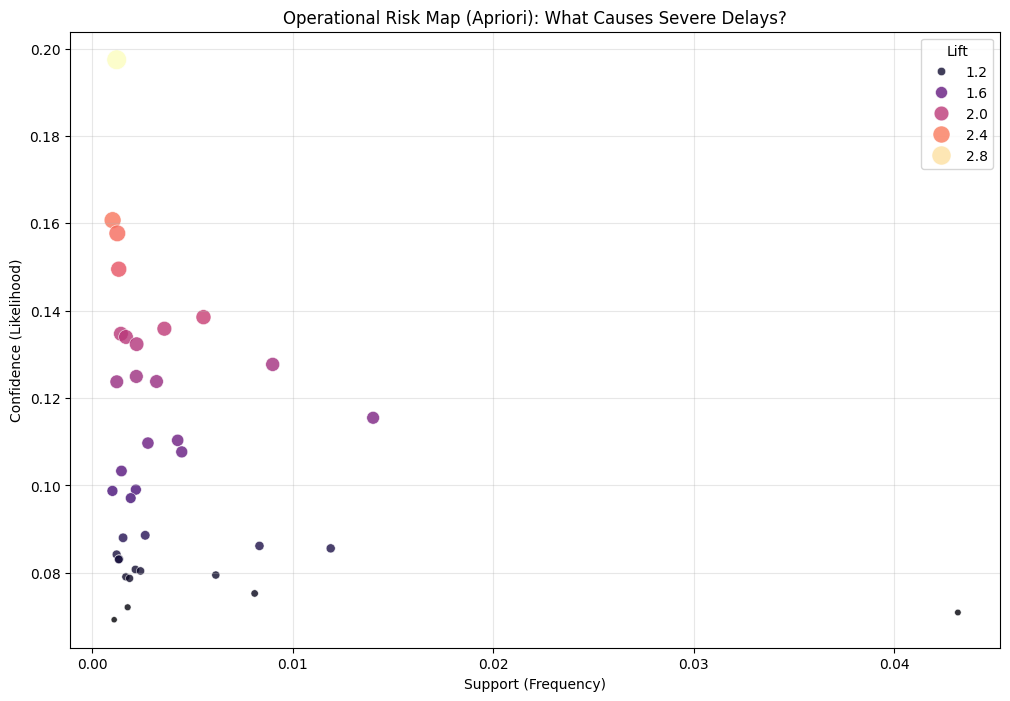

In [ ]:
print("\n--- 4. Analysis: Predictors of Severe Delays ---")

# Filter: Consequent must be SEVERE Delay
target = {'Delay_Class=Severe'}
severe_rules = rules[rules['consequents'] == target].copy()

severe_rules = severe_rules.sort_values('lift', ascending=False)

cols_show = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
print("TOP RISK FACTORS (Apriori Results):")
print(severe_rules[cols_show].head(15))

# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="support",
    y="confidence",
    size="lift",
    data=severe_rules,
    hue="lift",
    palette="magma",
    sizes=(20, 200),
    alpha=0.8
)
plt.title('Operational Risk Map (Apriori): What Causes Severe Delays?')
plt.xlabel('Support (Frequency)')
plt.ylabel('Confidence (Likelihood)')
plt.legend(title='Lift')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ==========================================
# CHUNK 6: EXPORTING ALL RULES
# ==========================================
print("--- 5. Exporting Full Rule Set ---")

pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_colwidth', None) 


all_rules_sorted = rules.sort_values('lift', ascending=False)

print("Top 50 Rules (All Consequences):")
cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
print(all_rules_sorted[cols].head(50))


filename = 'all_association_rules_full.csv'
all_rules_sorted.to_csv(filename, index=False)

print(f"\nSuccess! All {len(rules)} rules have been saved to '{filename}'.")
print("Open this file in Excel to explore the full dataset.")

--- 5. Exporting Full Rule Set ---
Top 50 Rules (All Consequences):
                                                                       antecedents  \
1274                                    (Weather_Snow, Tier_Name=Tier_3_Efficient)   
1275                              (Airline=Alaska Airlines Inc., Weather_Freezing)   
1272                                  (Weather_Snow, Airline=Alaska Airlines Inc.)   
1277                                (Weather_Freezing, Tier_Name=Tier_3_Efficient)   
1278                                                                (Weather_Snow)   
1271  (Airline=Alaska Airlines Inc., Weather_Freezing, Tier_Name=Tier_3_Efficient)   
1822                          (Airline=Hawaiian Airlines Inc., Delay_Class=OnTime)   
1827                                    (Tier_Name=Tier_3_Efficient, Weather_Wind)   
650                                     (Tier_Name=Tier_3_Efficient, Weather_Wind)   
651                                               (Airline=Hawaiian Airl